In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# curatedmetagenome samples

In [2]:
figure_output = '../../figures/exp03/5_figures'
scaanet_path = '../../data/scAAnet_output'
data_path = '../../data/only_healthy_data'

metadata = pd.read_csv(f'{data_path}/healthy_only_metadata_raw.csv', sep=',', index_col=0, header=0)
collection_samples = metadata[metadata['days_from_first_collection'].notna()]
subject_ids_with_multiple_samples = collection_samples['subject_id'].value_counts()[collection_samples['subject_id'].value_counts() > 1].index
multiple_samples = collection_samples[collection_samples['subject_id'].isin(subject_ids_with_multiple_samples)]
multiple_samples = multiple_samples[multiple_samples.disease == 'healthy']

# Step 1: Ensure 'days_from_first_collection' column is numeric
multiple_samples['days_from_first_collection'] = pd.to_numeric(multiple_samples['days_from_first_collection'], errors='coerce')
# Step 2: Identify subjects who have a sample with days_from_first_collection == 0
subjects_with_baseline = multiple_samples[multiple_samples['days_from_first_collection'] == 0]['subject_id'].unique()
# Step 3: Filter the DataFrame to include only subjects with a baseline sample (days_from_first_collection == 0)
filtered_samples = multiple_samples[multiple_samples['subject_id'].isin(subjects_with_baseline)]
# Step 4: Sort by subject_id and days_from_first_collection
filtered_samples = filtered_samples.sort_values(by=['subject_id', 'days_from_first_collection'])

In [3]:
import pickle
with open(f'{scaanet_path}/clean_100_rs.pkl', 'rb') as f:
    clean_100_states = pickle.load(f)
state53 = clean_100_states[(3,53)]
pathways = pd.read_csv(f'{data_path}/batchfix_paths_healthy_samples_pathway_counts.csv', sep=',', index_col=0, header=0)
usage = pd.DataFrame(state53['usage'])
usage.index = pathways.columns
usage.columns = ['type3', 'type1', 'type2']
desired_order = ['type1', 'type2', 'type3']
usage = usage[desired_order]

In [4]:
columns_df1 = set(usage.index)
columns_df2 = set(filtered_samples.index)
common_columns = columns_df1.intersection(columns_df2)
common_columns = list(common_columns)
usage_filtered = usage[usage.index.isin(common_columns)]
filtered_samples_filtered = filtered_samples[filtered_samples.index.isin(common_columns)]
# Rank visits by 'days_from_first_collection' within each subject and add visit number
filtered_samples_filtered['visit_number'] = (
    filtered_samples_filtered.groupby('subject_id')['days_from_first_collection']
    .rank(method='first')
    .astype(int)
)
filtered_samples_filtered['name_visit'] = (
    filtered_samples_filtered.index + 'V' + filtered_samples_filtered['visit_number'].astype(str)
)

/tmp/ipykernel_458084/4096370396.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_samples_filtered['visit_number'] = (
/tmp/ipykernel_458084/4096370396.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_samples_filtered['name_visit'] = (


In [5]:
# Identify duplicate combinations of 'subject_id' and 'days_from_first_collection'
duplicate_combinations = filtered_samples_filtered[filtered_samples_filtered.duplicated(subset=['subject_id', 'days_from_first_collection'], keep=False)]
filtered_samples_unique = filtered_samples_filtered.drop_duplicates(subset=['subject_id', 'days_from_first_collection'], keep='first')

In [6]:
# Step 1: Ensure 'days_from_first_collection' is numeric
filtered_samples_unique['days_from_first_collection'] = pd.to_numeric(filtered_samples_unique['days_from_first_collection'], errors='coerce')

# Step 2: Sort the DataFrame by subject_id and days_from_first_collection for proper comparison between visits
filtered_samples_unique = filtered_samples_unique.sort_values(by=['subject_id', 'days_from_first_collection'])

# Step 3: Merge usage data and sort
usage_merged = usage[usage.index.isin(filtered_samples_unique.index)]
merged_df = pd.merge(filtered_samples_unique, usage_merged, left_index=True, right_index=True)

# Step 4: Calculate the differences between visits for each subject
differences = []
for subject_id, group in merged_df.groupby('subject_id'):
    group = group.sort_values('days_from_first_collection')
    diff_values = group[['type1', 'type2', 'type3']].diff().iloc[1:]
    differences.append(diff_values)

all_differences = pd.concat(differences)

/tmp/ipykernel_458084/2308907959.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_samples_unique['days_from_first_collection'] = pd.to_numeric(filtered_samples_unique['days_from_first_collection'], errors='coerce')


In [7]:
filtered_samples_unique['days_from_first_collection'] = pd.to_numeric(filtered_samples_unique['days_from_first_collection'], errors='coerce')
# Step 1: Identify subjects who have both visit 1 (days_from_first_collection == 0) and visit 2 (days_from_first_collection >= 2.0)
subjects_with_visits_1_and_2 = filtered_samples_unique.groupby('subject_id').filter(
    lambda x: any(x['days_from_first_collection'] == 0) and any(x['days_from_first_collection'] >= 2.0)
)['subject_id'].unique()

# Step 2: Filter the DataFrame to include only samples with days_from_first_collection == 0 or days_from_first_collection >= 2.0
samples_with_atleast_2 = filtered_samples_unique[
    (filtered_samples_unique['subject_id'].isin(subjects_with_visits_1_and_2)) &
    ((filtered_samples_unique['days_from_first_collection'].isin([0]))|
    ((filtered_samples_unique['days_from_first_collection'] >= 2.0)))
]

# Sort the filtered samples by subject_id and days_from_first_collection for better readability
samples_with_atleast_2 = samples_with_atleast_2.sort_values(by=['subject_id', 'days_from_first_collection'])

# Display the filtered DataFrame
samples_with_atleast_2[['subject_id', 'sample_id', 'days_from_first_collection']]
usage_temp = usage[usage.index.isin(samples_with_atleast_2.index)]
usage_and_meta = pd.merge(samples_with_atleast_2, usage_temp, left_index=True, right_index=True)
usage_and_meta.index = usage_and_meta.index + 'V' + usage_and_meta.visit_number.astype(str)


In [8]:
binned_usage_cm = usage_and_meta.copy()

# Step 1: Define custom bin edges and labels
bin_edges = [0, 0.33, 0.67, 1]
bin_labels_1 = ['L1', 'M1', 'H1']
bin_labels_2 = ['L2', 'M2', 'H2']
bin_labels_3 = ['L3', 'M3', 'H3']

# Step 2: Use pd.cut() with the defined bins and labels for each type
binned_usage_cm['type1_binned'] = pd.cut(usage_and_meta['type1'], bins=bin_edges, labels=bin_labels_1, include_lowest=True)
binned_usage_cm['type2_binned'] = pd.cut(usage_and_meta['type2'], bins=bin_edges, labels=bin_labels_2, include_lowest=True)
binned_usage_cm['type3_binned'] = pd.cut(usage_and_meta['type3'], bins=bin_edges, labels=bin_labels_3, include_lowest=True)

# Step 3: Create new columns for combined labels with Visit prefix
for i in range(1,binned_usage_cm.visit_number.max()+1):
    binned_usage_cm[f'V{i}_combined_label'] = (
        f"V{i}_" + binned_usage_cm['type1_binned'].astype(str) + "_" +
        binned_usage_cm['type2_binned'].astype(str) + "_" +
        binned_usage_cm['type3_binned'].astype(str)
    )

In [9]:
# Initialize variables to store the cumulative totals across all transitions
cumulative_total_per_outer_key = {}
cumulative_same_label_counts = {}

# Define the range of visits (assuming visits are from 1 to 5)
visit_range = range(1, 6)

# Helper function to remove prefixes (V1_, V2_, etc.) from labels
def remove_prefix(label, prefix):
    return label.replace(f"{prefix}_", "")

# Loop through each consecutive pair of visits (1 to 2, 2 to 3, ..., 4 to 5)
for i in range(len(visit_range) - 1):
    visit_start = visit_range[i]
    visit_end = visit_range[i + 1]
    
    # Step 1: Filter data to include only samples that have both the current pair of visits
    visit_start_and_end = binned_usage_cm[binned_usage_cm['visit_number'].isin([visit_start, visit_end])]
    
    # Step 2: Pivot the data by subject_id and visit_number
    pivoted_usage = visit_start_and_end.pivot(index='subject_id', columns='visit_number', 
                                              values=[f'V{visit_start}_combined_label', f'V{visit_end}_combined_label'])
    
    # Step 3: Filter out rows where either visit in the pair is NaN
    valid_samples = pivoted_usage.dropna(subset=[(f'V{visit_start}_combined_label', visit_start), 
                                                 (f'V{visit_end}_combined_label', visit_end)])
    
    # Step 4: Group by the combined labels for both visits to count transitions
    grouped_data = valid_samples.groupby([valid_samples[f'V{visit_start}_combined_label'][visit_start], 
                                          valid_samples[f'V{visit_end}_combined_label'][visit_end]]).size()
    
    # Step 5: Create the plot_data dictionary for the current transition and remove the visit-specific prefixes
    plot_data = {}
    for (visit_start_label, visit_end_label), count in grouped_data.items():
        # Remove the prefixes (e.g., 'V1_', 'V2_', etc.) from the labels
        visit_start_label_clean = remove_prefix(visit_start_label, f'V{visit_start}')
        visit_end_label_clean = remove_prefix(visit_end_label, f'V{visit_end}')
        
        if visit_start_label_clean not in plot_data:
            plot_data[visit_start_label_clean] = {}
        plot_data[visit_start_label_clean][visit_end_label_clean] = count
    
    # Step 6: Calculate the total occurrences for each cleaned label
    total_per_outer_key = {outer_key: sum(inner_dict.values()) for outer_key, inner_dict in plot_data.items()}
    
    # Step 7: Calculate the counts of transitions that stayed in the same label (e.g., L1 -> L1)
    same_label_counts = {
        outer_key: inner_dict.get(outer_key, 0)  # Look for same label transition without prefixes
        for outer_key, inner_dict in plot_data.items()
    }
    
    # Step 8: Accumulate the totals and same label counts for all visits
    for outer_key in total_per_outer_key:
        cumulative_total_per_outer_key[outer_key] = cumulative_total_per_outer_key.get(outer_key, 0) + total_per_outer_key[outer_key]
        cumulative_same_label_counts[outer_key] = cumulative_same_label_counts.get(outer_key, 0) + same_label_counts[outer_key]
# Step 9: Calculate the percentage of stable transitions across all visits
cumulative_stable_transition_percentages = {
    outer_key: round((cumulative_same_label_counts[outer_key] / cumulative_total_per_outer_key[outer_key] * 100), 2)
    if cumulative_total_per_outer_key[outer_key] > 0 else 0
    for outer_key in cumulative_total_per_outer_key
}

# Step 10: Sort by percentage in descending order
sorted_cumulative_results = sorted(cumulative_stable_transition_percentages.items(), key=lambda item: item[1], reverse=True)

In [10]:
# Initialize an empty dictionary to store the transition data
transition_dict = {}

# Define the range of visits (assuming visits are from 1 to 5)
visit_range = range(1, 6)

# Helper function to completely remove 'V' prefixes and keep only the label (e.g., 'H1_L2_L3')
def clean_label(label):
    return label.split('_', 1)[-1]  # Removes the 'V1_', 'V2_', etc., part and keeps the rest of the label

# Loop through each consecutive pair of visits (1 to 2, 2 to 3, ..., 4 to 5)
for i in range(len(visit_range) - 1):
    visit_start = visit_range[i]
    visit_end = visit_range[i + 1]
    
    # Step 1: Filter data to include only samples that have both the current pair of visits
    visit_start_and_end = binned_usage_cm[binned_usage_cm['visit_number'].isin([visit_start, visit_end])]
    
    # Step 2: Pivot the data by subject_id and visit_number
    pivoted_usage = visit_start_and_end.pivot(index='subject_id', columns='visit_number', 
                                              values=[f'V{visit_start}_combined_label', f'V{visit_end}_combined_label'])
    
    # Step 3: Filter out rows where either visit in the pair is NaN
    valid_samples = pivoted_usage.dropna(subset=[(f'V{visit_start}_combined_label', visit_start), 
                                                 (f'V{visit_end}_combined_label', visit_end)])
    
    # Step 4: Group by the combined labels for both visits to count transitions
    grouped_data = valid_samples.groupby([valid_samples[f'V{visit_start}_combined_label'][visit_start], 
                                          valid_samples[f'V{visit_end}_combined_label'][visit_end]]).size()

    # Step 5: Populate the dictionary with the grouped data
    for (visit_start_label, visit_end_label), count in grouped_data.items():
        # Clean the labels by removing the 'V1_', 'V2_' prefixes
        clean_start_label = clean_label(visit_start_label)
        clean_end_label = clean_label(visit_end_label)
        
        # Ensure the outer dictionary for the starting visit exists
        if clean_start_label not in transition_dict:
            transition_dict[clean_start_label] = {}
        
        # Add the transition to the inner dictionary, summing counts if the label already exists
        if clean_end_label in transition_dict[clean_start_label]:
            transition_dict[clean_start_label][clean_end_label] += count
        else:
            transition_dict[clean_start_label][clean_end_label] = count

updated_dict = {}
# Loop through the existing dictionary and add 'T1_' to keys and 'T2_' to values
for start_label, end_dict in transition_dict.items():
    # Add 'T1_' to the start label
    new_start_label = f"T1_{start_label}"
    # Create a new inner dictionary with 'T2_' added to each end label
    new_end_dict = {f"T2_{end_label}": count for end_label, count in end_dict.items()}
    # Update the new dictionary
    updated_dict[new_start_label] = new_end_dict

# MI samples

In [11]:
usage = pd.read_csv(f'{scaanet_path}/mi_usage_cm.csv', sep=',', header=0, index_col = 0)
usage.columns = ['type3', 'type1', 'type2', 'Dominant type']
desired_order = ['type1', 'type2', 'type3', 'Dominant type']
usage['type1'] = pd.to_numeric(usage['type1'], errors='coerce')
usage['type2'] = pd.to_numeric(usage['type2'], errors='coerce')
usage['type3'] = pd.to_numeric(usage['type3'], errors='coerce')
numeric_cols = usage[['type1', 'type2', 'type3']]
usage['Dominant type'] = numeric_cols.idxmax(axis=1)
usage = usage[desired_order]

# Step 1: Extract the sample numbers from the index (ignoring the visit number)
extracted_samples = usage.index.str.extract(r'(\d+)[Vv]\d')[0]
# Step 2: Count the number of visits for each sample
sample_counts = extracted_samples.value_counts()
# Step 3: Filter samples that have exactly two visits
samples_with_two_visits = sample_counts[sample_counts == 2].index
# Step 4: Filter the original DataFrame by aligning the index
filtered_usage = usage[usage.index.to_series().str.extract(r'(\d+)[Vv]\d')[0].isin(samples_with_two_visits)]
filtered_usage['Sample'] = filtered_usage.index.to_series().str.extract(r'(\d+)[Vv]\d')[0].copy()
filtered_usage['Visit'] = filtered_usage.index.to_series().str.extract(r'[Vv](\d)')[0].copy()

/tmp/ipykernel_458084/4056012713.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_usage['Sample'] = filtered_usage.index.to_series().str.extract(r'(\d+)[Vv]\d')[0].copy()
/tmp/ipykernel_458084/4056012713.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_usage['Visit'] = filtered_usage.index.to_series().str.extract(r'[Vv](\d)')[0].copy()


In [12]:
pivoted_usage = filtered_usage.pivot(index='Sample', columns='Visit', values=['type1', 'type2', 'type3'])
# Compute the differences (Visit 2 - Visit 1)
pivoted_usage['type1_diff'] = pivoted_usage['type1']['2'] - pivoted_usage['type1']['1']
pivoted_usage['type2_diff'] = pivoted_usage['type2']['2'] - pivoted_usage['type2']['1']
pivoted_usage['type3_diff'] = pivoted_usage['type3']['2'] - pivoted_usage['type3']['1']
pivoted_usage = pivoted_usage.reset_index()


In [13]:
binned_usage = filtered_usage.copy()
# Step 1: Define custom bin edges and labels
bin_edges = [0, 0.33, 0.67, 1]
bin_labels_1 = ['L1', 'M1', 'H1']
bin_labels_2 = ['L2', 'M2', 'H2']
bin_labels_3 = ['L3', 'M3', 'H3']

# Step 2: Use pd.cut() with the defined bins and labels for each type
binned_usage['type1_binned'] = pd.cut(filtered_usage['type1'], bins=bin_edges, labels=bin_labels_1, include_lowest=True)
binned_usage['type2_binned'] = pd.cut(filtered_usage['type2'], bins=bin_edges, labels=bin_labels_2, include_lowest=True)
binned_usage['type3_binned'] = pd.cut(filtered_usage['type3'], bins=bin_edges, labels=bin_labels_3, include_lowest=True)

# Step 3: Create new columns for combined labels with Visit prefix
binned_usage['V1_combined_label'] = (
    "V1_" + binned_usage['type1_binned'].astype(str) + "_" +
    binned_usage['type2_binned'].astype(str) + "_" +
    binned_usage['type3_binned'].astype(str)
)

binned_usage['V2_combined_label'] = (
    "V2_" + binned_usage['type1_binned'].astype(str) + "_" +
    binned_usage['type2_binned'].astype(str) + "_" +
    binned_usage['type3_binned'].astype(str)
)

# Step 4: Pivot the data to create a DataFrame with 'Sample' as index and Visits as columns
pivoted_usage_plot = binned_usage.pivot(index='Sample', columns='Visit', values=['V1_combined_label', 'V2_combined_label'])

# Step 5: Group by the combined labels from Visit 1 and Visit 2 and count occurrences
grouped_data = pivoted_usage_plot.groupby([pivoted_usage_plot['V1_combined_label']['1'], pivoted_usage_plot['V2_combined_label']['2']]).size()

plot_data = {}
for (visit_1_label, visit_2_label), count in grouped_data.items():
    if visit_1_label not in plot_data:
        plot_data[visit_1_label] = {}
    plot_data[visit_1_label][visit_2_label] = count


# combining results

In [14]:
# all_differences is from curatedmetagenome dataset
# pivoted_usage is from MI dataset
# Extract differences from MI dataset
differences_dataset2 = pivoted_usage[['type1_diff', 'type2_diff', 'type3_diff']].copy()
# Rename columns to match those in curatedmetagenome dataset
differences_dataset2.columns = ['type1', 'type2', 'type3']
# Concatenate the differences from both datasets
combined_differences = pd.concat([all_differences, differences_dataset2], ignore_index=True)

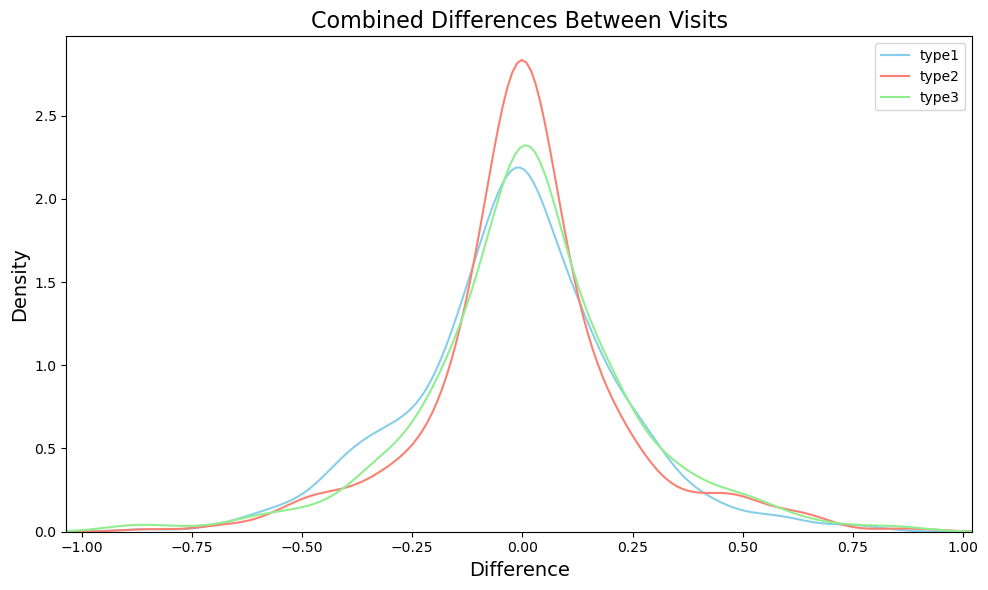

In [15]:
plt.figure(figsize=(10, 6))

# Find common axis limits for the combined plot
x_min = combined_differences.min().min()  # Minimum value across all columns
x_max = combined_differences.max().max()  # Maximum value across all columns

sns.kdeplot(combined_differences['type1'].dropna(), color='skyblue', label=f'type1')
sns.kdeplot(combined_differences['type2'].dropna(), color='salmon', label=f'type2')
sns.kdeplot(combined_differences['type3'].dropna(), color='lightgreen', label=f'type3')

plt.title('Combined Differences Between Visits', fontsize=16)
plt.xlabel('Difference', fontsize=14)
plt.ylabel('Density', fontsize=14)

plt.xlim(x_min - 0.1, x_max + 0.1)

plt.legend()

plt.tight_layout()
plt.savefig(f'{figure_output}/figure5A_stability_densityplot.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()


In [16]:
updated_plot_data = {}
# Loop through plot_data and update the prefixes
for start_label, end_dict in plot_data.items():
    # Change 'V1_' to 'T1_' in the start label
    new_start_label = start_label.replace('V1_', 'T1_')
    
    # Create a new inner dictionary with 'V2_' replaced by 'T2_'
    new_end_dict = {end_label.replace('V2_', 'T2_'): count for end_label, count in end_dict.items()}
    
    # Add the modified entry to updated_plot_data
    updated_plot_data[new_start_label] = new_end_dict

merged_dict = {}
# Merge updated_dict into merged_dict
for start_label, end_dict in updated_dict.items():
    if start_label not in merged_dict:
        merged_dict[start_label] = end_dict.copy()
    else:
        # If start_label exists, merge inner dictionaries
        for end_label, count in end_dict.items():
            if end_label in merged_dict[start_label]:
                merged_dict[start_label][end_label] += count
            else:
                merged_dict[start_label][end_label] = count

# Merge updated_plot_data into merged_dict
for start_label, end_dict in updated_plot_data.items():
    if start_label not in merged_dict:
        merged_dict[start_label] = end_dict.copy()
    else:
        # If start_label exists, merge inner dictionaries
        for end_label, count in end_dict.items():
            if end_label in merged_dict[start_label]:
                merged_dict[start_label][end_label] += count
            else:
                merged_dict[start_label][end_label] = count



In [17]:
# Convert merged_dict to a DataFrame
df = pd.DataFrame.from_dict(merged_dict, orient='index').fillna(0)

# Convert counts to percentages
row_sums = df.sum(axis=1)
percentage_data = df.div(row_sums, axis=0) * 100  
sorted_index = sorted(percentage_data.index.unique())
sorted_columns = sorted(percentage_data.columns.unique())

# Reindex the DataFrame so that rows and columns are in the same sorted order
percentage_data = percentage_data.reindex(index=sorted_index, columns=sorted_columns)

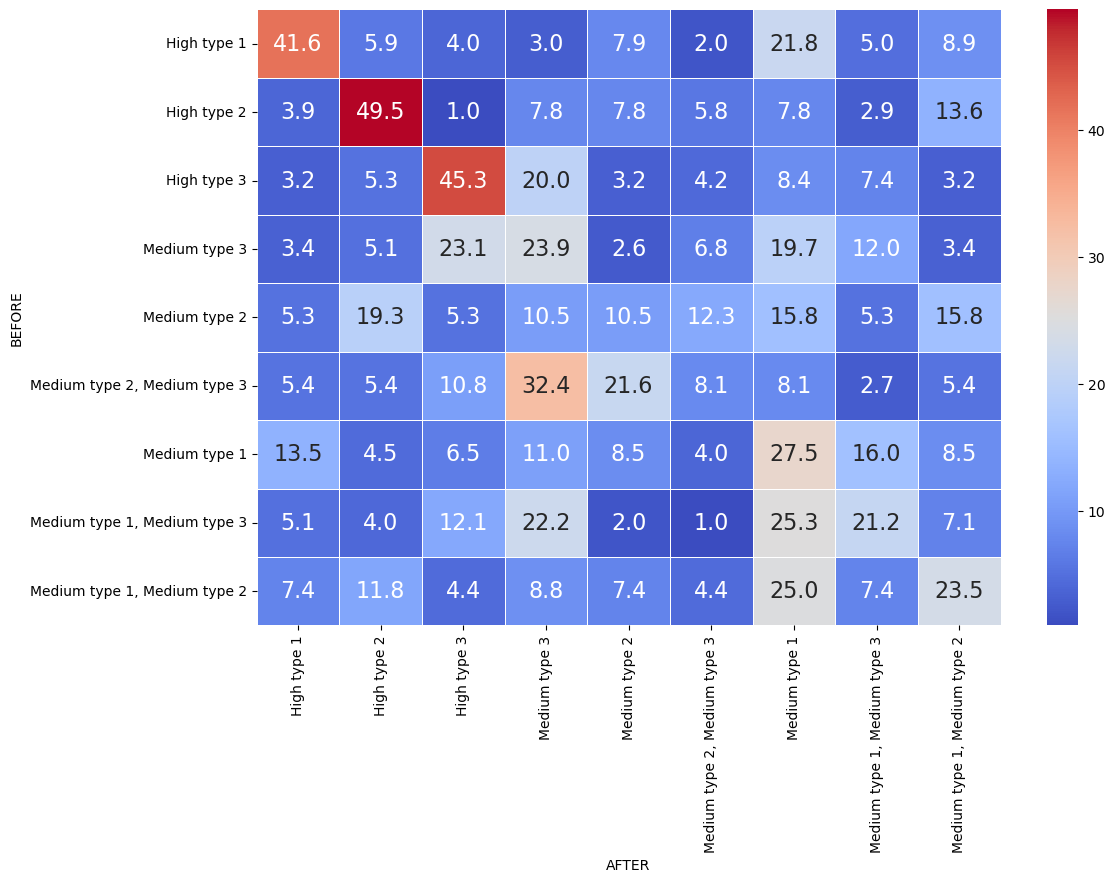

In [18]:
label_mapping = {
    'H1': 'High type 1',
    'H2': 'High type 2',
    'H3': 'High type 3',
    'M1': 'Medium type 1',
    'M2': 'Medium type 2',
    'M3': 'Medium type 3'
}

def extract_labels(label):
    parts = label.split('_')
    lparts = [part for part in parts if part in label_mapping]
    return ', '.join([label_mapping[part] for part in lparts]) if lparts else label

# Apply the label conversion to both row and column labels
filtered_percentage_data_high = percentage_data.copy()
filtered_percentage_data_high.index = percentage_data.index.map(extract_labels)
filtered_percentage_data_high.columns = percentage_data.columns.map(extract_labels)

plt.figure(figsize=(12, 8))
sns.heatmap(filtered_percentage_data_high, annot=True, cmap='coolwarm', fmt=".1f", linewidths=.5,annot_kws={"size": 16})

plt.xlabel('AFTER')
plt.ylabel('BEFORE')
plt.savefig(f'{figure_output}/figure5B_all_samples_transition_heatmap.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()
